In [1]:
import os
os.chdir("../")
%pwd

'd:\\Final-Year-Project\\Credit-Card-Fraud-Detection-Using-GNN'

In [3]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    data_path: Path 
    model_name: str
    hidden_channels: int
    learning_rate: float
    epochs: int


In [4]:
from Credit_Card_Fraud_Detection.constants import *
from Credit_Card_Fraud_Detection.utils.common import read_yaml, create_directories

In [5]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config.model_trainer
        params = self.params.GCN 

        create_directories([config.root_dir])

        model_trainer_config = ModelTrainerConfig(
            root_dir=config.root_dir,
            data_path=config.data_path, 
            model_name=config.model_name,
            hidden_channels=params.hidden_channels,
            learning_rate=params.learning_rate,
            epochs=params.epochs,
        )

        return model_trainer_config

In [ ]:

import os
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import HeteroConv, SAGEConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from Credit_Card_Fraud_Detection import logger


In [7]:


class GNN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim):
        super(GNN, self).__init__()
        self.conv1 = HeteroConv({edge_type: SAGEConv((-1, -1), hidden_dim) for edge_type in metadata[1]}, aggr='mean')
        self.conv2 = HeteroConv({edge_type: SAGEConv((-1, -1), hidden_dim) for edge_type in metadata[1]}, aggr='mean')
        self.conv3 = HeteroConv({edge_type: SAGEConv((-1, -1), hidden_dim) for edge_type in metadata[1]}, aggr='mean') # Added layer
        self.lin = torch.nn.Linear(hidden_dim, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = {key: self.dropout(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()} #Added activation
        x_dict = {key: self.dropout(x) for key, x in x_dict.items()} #Added dropout
        x_dict = self.conv3(x_dict, edge_index_dict) #Added layer
        return self.lin(x_dict["transaction"]).squeeze(-1)
        
class GNNModelTrainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.data = torch.load(self.config.data_path).to(self.device)
        self.model = self._build_model().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.learning_rate)

        num_non_fraud = (self.data["transaction"].y[self.data["transaction"].train_mask] == 0).sum().item()
        num_fraud = (self.data["transaction"].y[self.data["transaction"].train_mask] == 1).sum().item()
        fraud_weight = (num_non_fraud / num_fraud) * 0.5
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([fraud_weight], device=self.device))

    def _build_model(self):
        metadata = (list(self.data.x_dict.keys()), list(self.data.edge_index_dict.keys()))
        return GNN(metadata, hidden_dim=self.config.hidden_channels)

    def train(self):
        self.model.train()
        self.optimizer.zero_grad()

        out = self.model(self.data.x_dict, self.data.edge_index_dict)
        train_mask = self.data["transaction"].train_mask

        loss = self.criterion(out[train_mask], self.data["transaction"].y[train_mask].squeeze(1))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        torch.cuda.empty_cache()

        return loss.item()

    def evaluate(self):
        self.model.eval()
        with torch.no_grad():
            out = torch.sigmoid(self.model(self.data.x_dict, self.data.edge_index_dict))
            test_mask = self.data["transaction"].test_mask

            y_true = self.data["transaction"].y[test_mask].cpu().numpy()
            y_pred = out[test_mask].cpu().numpy()

            auc = roc_auc_score(y_true, y_pred)
            y_pred_labels = (y_pred > 0.5).astype(int)
            precision = precision_score(y_true, y_pred_labels)
            recall = recall_score(y_true, y_pred_labels)
            f1 = f1_score(y_true, y_pred_labels) # changed r2 to f1

            self.plot_auc_roc(y_true, y_pred, "Test ROC Curve")
            self.plot_confusion_matrix(y_true, y_pred, "Test Confusion Matrix")

            logger.info(f"Testing on {test_mask.sum().item()} rows.")
            logger.info(f"Test AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}") # changed r2 to f1

        return auc

    def plot_auc_roc(self, y_true, y_pred, title):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_true, y_pred):.4f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, title):
        y_pred_labels = (y_pred > 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title)
        plt.show()

    def run_training(self):
        train_mask = self.data["transaction"].train_mask
        logger.info(f"Training on {train_mask.sum().item()} rows.")

        for epoch in range(self.config.epochs):
            loss = self.train()
            if epoch % 10 == 0 or epoch == self.config.epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        auc = self.evaluate()
        print(f"Final AUC: {auc:.4f}")

        # Save the trained model
        self.save_model()

    def save_model(self):
        model_save_dir = self.config.root_dir
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, self.config.model_name)
        torch.save(self.model.state_dict(), model_save_path)
        logger.info(f"Trained model saved to: {model_save_path}")

        


[2025-03-22 22:34:54,372: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-22 22:34:54,372: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-22 22:34:54,375: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-03-22 22:34:54,376: INFO: common: created directory at: artifacts]
[2025-03-22 22:34:54,378: INFO: common: created directory at: artifacts/model_trainer]


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15816\2604188660.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(self.config.data_path).to(self.devi

[2025-03-22 22:34:55,211: INFO: 2604188660: Training on 1037340 rows.]
Epoch 0, Loss: 1.0001
Epoch 10, Loss: 0.5725
Epoch 20, Loss: 0.5112
Epoch 30, Loss: 0.4526
Epoch 40, Loss: 0.4081
Epoch 49, Loss: 0.3770


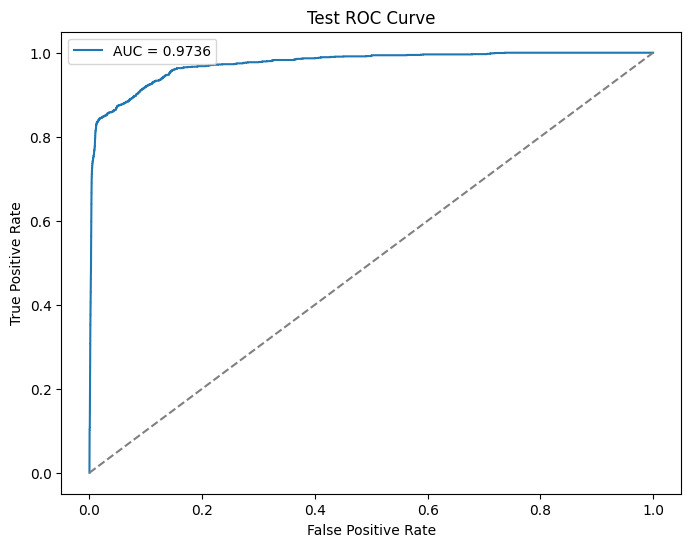

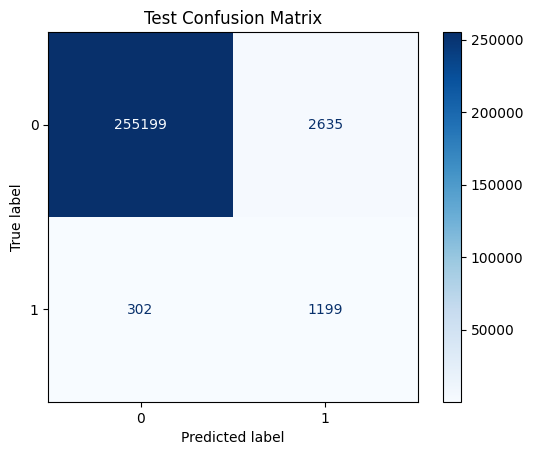

[2025-03-22 22:35:03,582: INFO: 2604188660: Testing on 259335 rows.]
[2025-03-22 22:35:03,582: INFO: 2604188660: Test AUC: 0.9736, Precision: 0.3127, Recall: 0.7988, F1: 0.4495]
Final AUC: 0.9736
[2025-03-22 22:35:03,591: INFO: 2604188660: Trained model saved to: artifacts/model_trainer\fraud_detection_gcn.pth]


In [8]:
try:
    config_manager = ConfigurationManager()
    model_trainer_config = config_manager.get_model_trainer_config()
    trainer = GNNModelTrainer(model_trainer_config)
    trainer.run_training()

except Exception as e:
    logger.exception("An error occurred during model training.")
    raise e